# Final Project - SQL Code

#### SQL Database

Generate SQL database and import tables.

In [ ]:
conn = sqlite3.connect("final.db")
c = conn.cursor()

NameError: name 'sqlite3' is not defined

In [ ]:
# Run create table sql query
c.execute("""CREATE TABLE IF NOT EXISTS CPI_final
             (Homecooked_or_Takeout, Food Category, Attribute,
       Percent Change)""")

In [ ]:
CPI_final.to_sql('final', conn, if_exists='replace', index=False)

In [ ]:
tables = {
    'nut_intake_long_final': nut_intake_long_final,
    'nut_intake_wide_final': nut_intake_wide_final,
    'food_group_long_final': food_group_long_final,
    'food_group_wide_final': food_group_wide_final,
    'density_long_final': density_long_final,
    'density_wide_final': density_wide_final,
    'rec_density_final': rec_density_final,
    'sales_final': sales_final,
    'sales_percapita_final': sales_percapita_final,
    'sales_NTT_final': sales_NTT_final,
    'sales_percapNTT_final': sales_percapNTT_final,
    'size_final': size_final
}

for name, df in tables.items():
    df.to_sql(name, conn, if_exists='replace', index=False)

### SQL Query 1: Nutrient Intake Changes Over Time

What: We wanted to create a table that shows the nutrient intake for 2007 and 2017 and the percent change over that period of time.

Why: To show how nutrient intake has changed over time.

How: The code filters for data from both these years from the original table, subqueries a table that renames two fields (Energy and Total Energy) and joins them with the nutrient data from both years. Then the code groups by nutrient and filters for the 2007/2017 nutrient intake amount and finally calculates the percent change. Everything in the table is then ordered by the percent change. The output shows a table with nutrient, intake amounts for 2007/2017 and the percent change over that time.

This query features a CTE, subqueries, joins, group by and windows functions.

An example of the output is below showing a table with nutrient group, intake for 2007 and 2017 and the percent change.

In [ ]:
query = """
-- SQL Query: Nutrient Intake in 2007 vs 2017
WITH filtered AS (
    SELECT * FROM nut_intake_wide_final WHERE Year IN (2007, 2017)
),
long_format AS (
    SELECT Year, 'Energy (kcal)' AS Nutrient, "Total Energy" AS Value FROM filtered
    UNION ALL SELECT Year, 'Total Fat (%)', "Total Total Fat" FROM filtered
    UNION ALL SELECT Year, 'Saturated Fat (%)', "Total Saturated fatty acids" FROM filtered
    UNION ALL SELECT Year, 'Fiber (g)', "Total Fiber, dietary" FROM filtered
    UNION ALL SELECT Year, 'Protein (g)', "Total Protein" FROM filtered
    UNION ALL SELECT Year, 'Calcium (mg)', "Total Calcium" FROM filtered
    UNION ALL SELECT Year, 'Iron (mg)', "Total Iron" FROM filtered
    UNION ALL SELECT Year, 'Sodium (mg)', "Total Sodium" FROM filtered
),
pivoted AS (
    SELECT
        Nutrient,
        MAX(CASE WHEN Year = 2007 THEN Value END) AS Intake_2007,
        MAX(CASE WHEN Year = 2017 THEN Value END) AS Intake_2017
    FROM long_format
    GROUP BY Nutrient
)
SELECT
    Nutrient,
    ROUND(Intake_2007, 2) AS Intake_2007,
    ROUND(Intake_2017, 2) AS Intake_2017,
    ROUND((Intake_2017 - Intake_2007) * 100.0 / Intake_2007, 2) AS Percent_Change
FROM pivoted
ORDER BY Percent_Change DESC;
"""

table3_sql_result = pd.read_sql(query, conn)
table3_sql_result

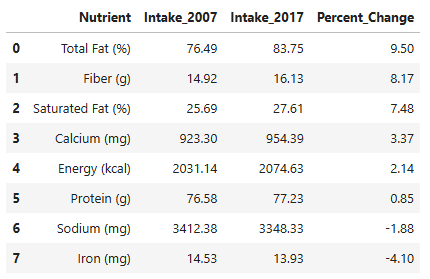

#### SQL Query 2: Actual Nutrient Density vs. USDA Recommendations

What: This query compares estimated nutrient density amounts that Americans intake to the USDA recommended nutrient density amounts.

Why: To understand trends in the difference between recommended nutrient density and estimates of the actual nutrient density Amerians are consuming.

How: This SQL query compares the actual nutrient density vs the USDA recommended nutrient density. The code joins the nutrient information from the recommended density table to the actual nutrient intake table and then calculates the difference between the actual and recommended values.

The SQL query features a CTE, joins & subqueries.

An example of the output is below, it shows a table with nutrient, year, nutrient density information and the delta between recommended and actual nutrient density.

In [ ]:
# SQL query to compare actual nutrient density vs USDA recommendations
query = """
WITH nutrient_map AS (
    SELECT 'Fiber (g)' AS RecLabel, 'Total Fiber, dietary' AS ActualColumn
    UNION ALL SELECT 'Saturated fats (percent of calories)**', 'Total Saturated fatty acids'
    UNION ALL SELECT 'Calcium (mg)', 'Total Calcium'
    UNION ALL SELECT 'Iron (mg)', 'Total Iron'
    UNION ALL SELECT 'Sodium (mg)', 'Total Sodium'
),
base AS (
    SELECT
        r."Nutrient or Food group" AS Nutrient,
        r.RecDensity_per1000cal AS Recommended,
        n.Year,
        CASE
            WHEN r."Nutrient or Food group" = 'Fiber (g)' THEN n."Total Fiber, dietary"
            WHEN r."Nutrient or Food group" = 'Saturated fats (percent of calories)**' THEN n."Total Saturated fatty acids"
            WHEN r."Nutrient or Food group" = 'Calcium (mg)' THEN n."Total Calcium"
            WHEN r."Nutrient or Food group" = 'Iron (mg)' THEN n."Total Iron"
            WHEN r."Nutrient or Food group" = 'Sodium (mg)' THEN n."Total Sodium"
        END AS Actual
    FROM rec_density_final r
    JOIN nutrient_map m ON r."Nutrient or Food group" = m.RecLabel
    JOIN nut_intake_wide_final n
),
final AS (
    SELECT
        Nutrient,
        Year,
        ROUND(Recommended, 2) AS Recommended,
        ROUND(Actual, 2) AS Actual,
        ROUND(Actual - Recommended, 2) AS Delta,
        ROUND((Actual - Recommended) * 100.0 / Recommended, 2) AS Percent_Deviation
    FROM base
    WHERE Actual IS NOT NULL
)
SELECT * FROM final
ORDER BY Nutrient, Year;
"""

# Run SQL and store result
table4_sql_result = pd.read_sql(query, conn)
table4_sql_result.head()

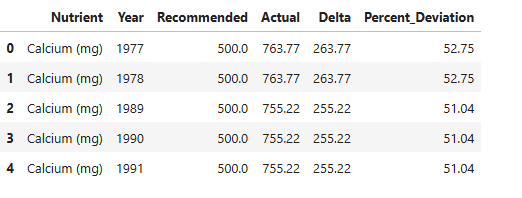

#### Query 3: State Share of Total Expenditure per Region

What: This query provides the share of total expenditures from each state of a region.

Why: We wanted to investigate expenditures for each state compared to total expenditure of each region of the United States.

How: The code takes the sum of "Total Sales" of all the states in each region then calculates the share expenditures for each state. This is ordered by region and total sales amount so users can see the states with the largest share of expenditures by region.

This code features a windows function.

The output example below shows a table with all states in the Midwest region and the share of total sales for the region each state had for the year 2023.

In [ ]:
query=""" SELECT *,
            "Total Sales (Nominal $M)"/sum("Total Sales (Nominal $M)") OVER (PARTITION BY Region) AS Share_Total_Sales
            FROM q1_sales_table
            WHERE Year == 2023
            ORDER BY Region, "Total Sales (Nominal $M)" DESC;
"""

max_statesales = pd.read_sql(query, conn)
max_statesales

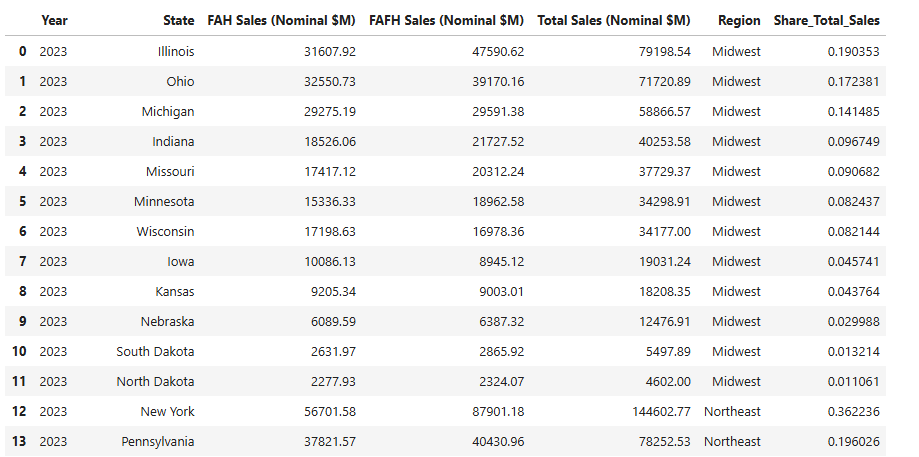

### Query 4: Normalized FAFH Nutrient Trends (Chart 4)
What: This query creates a normalized view (0 to 1 scale) of key nutrient intake from Food Away From Home (FAFH) sources over time.

Why: To visualize how intake of different nutrients has evolved relative to each nutrient's own minimum and maximum values, enabling easier comparison of trend shapes across nutrients.

How: The query reshapes the data into long format, maps nutrient labels between the two data sets, calculates min and max for each nutrient using a CTE, and applies min-max normalization for each (value - min) / (max - min).

The output example is shown below, it includes a table with rows for each year of data, the nutrient and the normalized value of the nutrient intake.


In [ ]:
query = """
-- Query #1: Normalized FAFH Nutrient Trends (Chart 4)
-- What: This query creates a normalized view (0 to 1 scale) of key nutrient intake from Food Away From Home (FAFH) sources over time.
-- Why: To visualize how intake of different nutrients has evolved relative to each nutrient's own minimum and maximum values, enabling easier comparison of trend shapes across nutrients.
-- How: The query reshapes the data into long format, calculates min and max for each nutrient using a CTE, and applies min-max normalization for each (value - min) / (max - min).

WITH long_format AS (
    SELECT Year, 'FAFH Calcium' AS Nutrient, "FAFH Calcium" AS Value FROM nut_intake_wide_final
    UNION ALL SELECT Year, 'FAFH Fiber, dietary', "FAFH Fiber, dietary" FROM nut_intake_wide_final
    UNION ALL SELECT Year, 'FAFH Iron', "FAFH Iron" FROM nut_intake_wide_final
    UNION ALL SELECT Year, 'FAFH Protein', "FAFH Protein" FROM nut_intake_wide_final
    UNION ALL SELECT Year, 'FAFH Energy', "FAFH Energy" FROM nut_intake_wide_final
    UNION ALL SELECT Year, 'FAFH Saturated fatty acids', "FAFH Saturated fatty acids" FROM nut_intake_wide_final
    UNION ALL SELECT Year, 'FAFH Sodium', "FAFH Sodium" FROM nut_intake_wide_final
),
min_max AS (
    SELECT Nutrient,
           MIN(Value) AS Min_Val,
           MAX(Value) AS Max_Val
    FROM long_format
    GROUP BY Nutrient
)
SELECT
    l.Year,
    l.Nutrient,
    ROUND((l.Value - m.Min_Val) * 1.0 / (m.Max_Val - m.Min_Val), 4) AS Normalized_Value
FROM long_format l
JOIN min_max m ON l.Nutrient = m.Nutrient
ORDER BY l.Nutrient, l.Year;
"""

chart4_sql_result = pd.read_sql(query, conn)
chart4_sql_result.head()

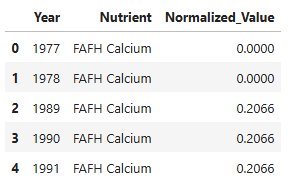

### Query 5: Distribution of Per Capita Food Sales by State (Chart 5)
What: This query retrieves total per capita food sales (including taxes and tips) across all U.S. states from 1997 to 2023.

Why: To analyze how food spending per person varies by state and identify spending patterns or disparities.

How: This is a simple select query that pulls the relevant per capita column from the cleaned sales dataset.

The output shows a table of each state, year and per capita sales information. An example is below.

In [ ]:
SELECT
    State,
    Year,
    "Total sales per capita nominal U.S. dollars with taxes and tips" AS PerCapitaSales
FROM sales_percapita_final
WHERE "Total sales per capita nominal U.S. dollars with taxes and tips" IS NOT NULL
ORDER BY State, Year;
"""

chart5_sql_result = pd.read_sql(query, conn)
chart5_sql_result.head()

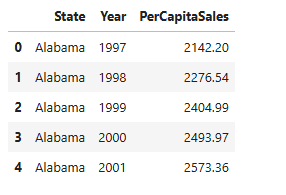

### Chart 6: Nutrient Deviation from Recommendations  

This code creates a table that includes nutrients, year, and calculates the difference between recommended intake and actual intake estimates.

This code was included in our analysis but not used as one of our 12 SQL codes.

In [ ]:
query = """
WITH nutrient_map AS (
    SELECT 'Fiber (g)' AS RecLabel, 'Total | Fiber, dietary' AS ActualColumn
    UNION ALL SELECT 'Saturated fats (percent of calories)**', 'Total | Saturated fatty acids'
    UNION ALL SELECT 'Calcium (mg)', 'Total | Calcium'
    UNION ALL SELECT 'Iron (mg)', 'Total | Iron'
    UNION ALL SELECT 'Sodium (mg)', 'Total | Sodium'
),
base AS (
    SELECT
        r."Nutrient or Food group" AS Nutrient,
        r.RecDensity_per1000cal AS Recommended,
        n.Year,
        CASE
            WHEN r."Nutrient or Food group" = 'Fiber (g)' THEN n."Total | Fiber, dietary"
            WHEN r."Nutrient or Food group" = 'Saturated fats (percent of calories)**' THEN n."Total | Saturated fatty acids"
            WHEN r."Nutrient or Food group" = 'Calcium (mg)' THEN n."Total | Calcium"
            WHEN r."Nutrient or Food group" = 'Iron (mg)' THEN n."Total | Iron"
            WHEN r."Nutrient or Food group" = 'Sodium (mg)' THEN n."Total | Sodium"
        END AS Actual
    FROM rec_density_final r
    JOIN nutrient_map m ON r."Nutrient or Food group" = m.RecLabel
    JOIN nut_intake_wide_final n
),
final AS (
    SELECT
        Nutrient,
        Year,
        ROUND(Recommended, 2) AS Recommended,
        ROUND(Actual, 2) AS Actual,
        ROUND(Actual - Recommended, 2) AS Delta,
        ROUND((Actual - Recommended) * 100.0 / Recommended, 2) AS Percent_Deviation
    FROM base
    WHERE Actual IS NOT NULL
)
SELECT * FROM final
ORDER BY Nutrient, Year;
"""

chart6_sql_untidy = pd.read_sql(query, conn)

### Query 6: Join Spending and Nutrient Intake Data
What: We created a table that joined spending and nutrient intake data.

Why: To evaluate if higher spending is associated with healthier nutrient consumption.

How: The code selects the fields desired from the sales data, calculates the average per capital spend for each year using AVG() OVER (PARTITION BY) and then joins this data to the nutrient intake data filtering out NULL values.

Techniques used: Join, filtering, derived columns, windows function

The output creates a table with the nutrient data, and percapita spending for each state.

In [ ]:
query = """
-- SQL Query: Join Spending and Nutrient Intake Data
-- Why: To evaluate if higher spending is associated with healthier nutrient consumption.
-- Techniques used: Join, filtering, derived columns

SELECT
    s.Year,
    s."Total sales per capita nominal U.S. dollars with taxes and tips" AS PerCapitaSpending,
    n."Total Fiber, dietary" AS Fiber,
    n."Total Protein" AS Protein,
    n."Total Saturated fatty acids" AS SatFat,
    AVG(s."Total sales per capita nominal U.S. dollars with taxes and tips") OVER (PARTITION BY s.Year) AS Rolling_Avg_Spending
FROM
    sales_percapita_final s
JOIN
    nut_intake_wide_final n
    ON s.Year = n.Year
WHERE
    s."Total sales per capita nominal U.S. dollars with taxes and tips" IS NOT NULL
    AND n."Total Fiber, dietary" IS NOT NULL
    AND n."Total Protein" IS NOT NULL
    AND n."Total Saturated fatty acids" IS NOT NULL
"""

# Run SQL and load results
df_model = pd.read_sql(query, conn)

# Group to year level: average spending, national nutrient values (since nutrients already represent national data)
df_avg = df_model.groupby('Year', as_index=False).agg({
    'PerCapitaSpending': 'mean',
    'Fiber': 'first',
    'Protein': 'first',
    'SatFat': 'first'
})

### Query 7: State with Highest Expenditure

What: This query allows us to input different years and get an output of the state with the highest total sales expenditure in nominal US dollars.

Why: To easily pin point which state in a given year had the top sales expenditure on food.

How: The code uses a parameterized SQL query that filters the sales data by year and matches the max value of the total sales for that year.

This query uses subqueries and window functions.

The output (example below) would be a single observation for the year that was inputted.

In [ ]:
def top_state_sales_by_year(conn, year):
    query = """
    SELECT Year, State,
           "FAH sales million nominal U.S. dollars with taxes and tips" AS FAH_Sales_nominal,
           "FAFH sales million nominal U.S. dollars with taxes and tips" AS FAFH_Sales_nominal,
           "Total sales million nominal U.S. dollars with taxes and tips" AS Total_Sales_nominal
    FROM sales_final
    WHERE Year = ?
      AND "Total sales million nominal U.S. dollars with taxes and tips" = (
          SELECT MAX("Total sales million nominal U.S. dollars with taxes and tips")
          FROM sales_final
          WHERE Year = ?
      )
    """
    return pd.read_sql(query, conn, params=(year, year))

In [ ]:
# example output
result = top_state_sales_by_year(conn, 2020)
print(result)

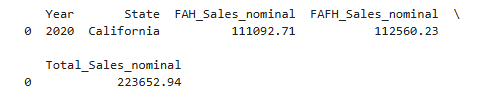

### Query 8: Food Groups ranked by Highest Recommended Density

What: This code ranks food groups that have the highest recommended density per 1000 cal.

Why: To easily identify which food groups have the highest (or lowest) recommended densities.

How: First this code selects for all columns from the recommended food density table. Then it ranks over the recommended density column starting with the highest density and then it removes any food groups with a null value.

This code uses a window function.

The output shows a table of ranked nutrient/food groups (below).

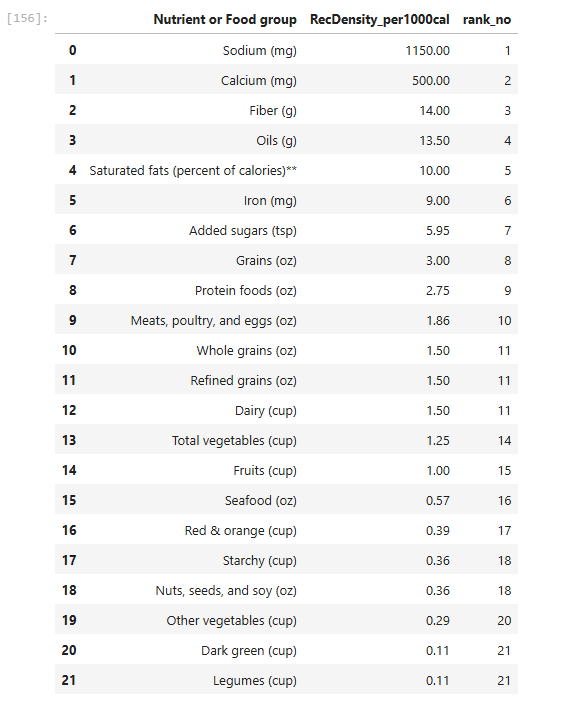

In [ ]:
query="""
  SELECT *, RANK() OVER(ORDER BY "RecDensity_per1000cal" DESC) AS rank_no
  FROM rec_density_final
  WHERE RecDensity_per1000cal <> "NULL";

"""
test = pd.read_sql(query, conn)
test

## Query 9: Total FAH vs. FAFH Sales by Region
What: This query calculates total sales of food-at-home (FAH) and food-away-from-home (FAFH) across all U.S. regions.

Why: To compare how much consumers in each region rely on at-home versus away-from-home food sources — a key behavioral insight for regional consumption trends.

How: This is a GROUP BY query that aggregates sales across all years in the dataset, summing the FAH and FAFH values by region.

The output below includes a table with the total sum of spending per region for food away from home (FAFH) and food at home (FAH).

In [ ]:
query9 = """
SELECT Region,
       SUM("FAH sales million nominal U.S. dollars with taxes and tips") AS FAH_Total,
       SUM("FAFH sales million nominal U.S. dollars with taxes and tips") AS FAFH_Total
FROM q1_sales_table
GROUP BY Region;
"""
query9_result = pd.read_sql(query9, conn)
query9_result


NameError: name 'pd' is not defined

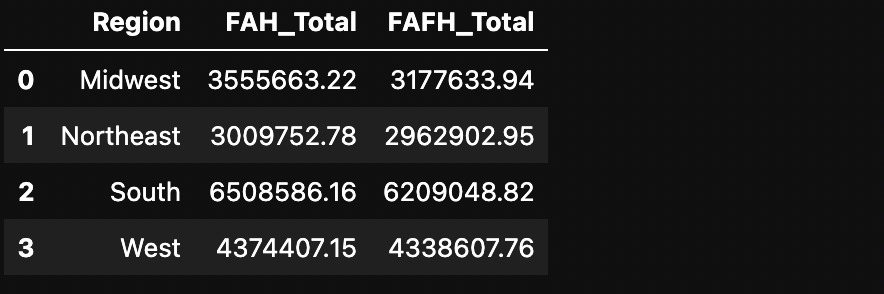

## Query 10: Year-Over-Year Growth in FAH and FAFH Sales

What: This query calculates the annual growth in FAH and FAFH sales for each region by comparing consecutive years.

Why: To assess whether people are increasingly eating out or at home over time, and how that shift differs across regions.

How: This query performs a self-join on the sales table by region and year (offset by 1) and calculates the difference in sales between each year and the previous year.

This features a join.

The output shows a table with expenditure growth by region for every year where there is data available.


In [ ]:
query10 = """
SELECT a.Year,
       a.Region,
       a."FAFH sales million nominal U.S. dollars with taxes and tips" - b."FAFH sales million nominal U.S. dollars with taxes and tips" AS FAFH_Growth,
       a."FAH sales million nominal U.S. dollars with taxes and tips" - b."FAH sales million nominal U.S. dollars with taxes and tips" AS FAH_Growth
FROM q1_sales_table a
JOIN q1_sales_table b ON a.Region = b.Region AND a.Year = b.Year + 1;
"""
query10_result = pd.read_sql(query10, conn)
query10_result

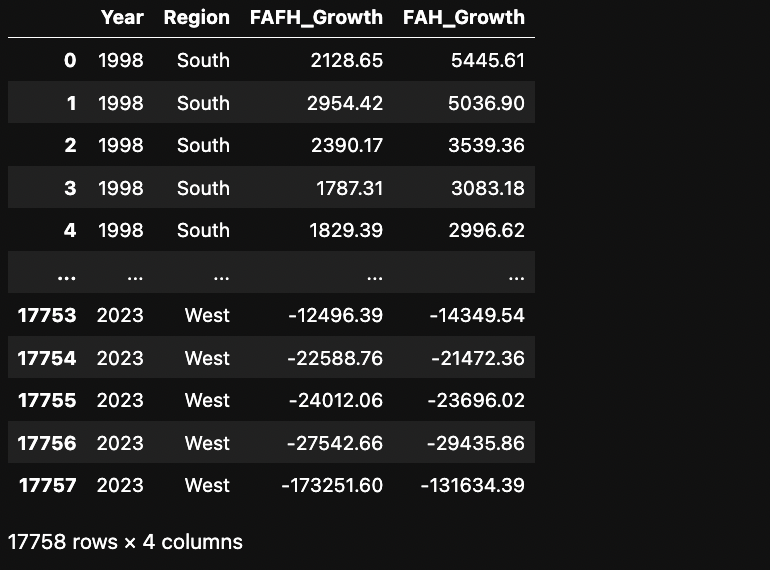

## Query 11: Ranking Food Types by National Sales
What: This query ranks all food groups (e.g., dairy, grains, mixed dishes) based on total estimated intake across all years and sources.

Why: To identify which food categories dominate the American diet, offering insight into which groups are most heavily consumed and may carry the greatest nutritional or public health impact.

How: The query uses a GROUP BY to sum total intake by food group, and a window function (RANK() OVER) to assign rankings in descending order. This allows for a clear comparison of relative consumption volumes across categories.

This query features a window function and a GROUP BY.

The output displays a ranked table of food groups by total intake.

In [ ]:
query11 = """
SELECT
    "Group" AS "Food Group",
    ROUND(SUM(Value), 2) AS Total_Intake,
    RANK() OVER (ORDER BY SUM(Value) DESC) AS Rank
FROM food_group_long_final
WHERE "Group" != 'Group'  -- filter out bad header row
GROUP BY "Group"
ORDER BY Rank;
"""

pd.read_sql(query11, conn)

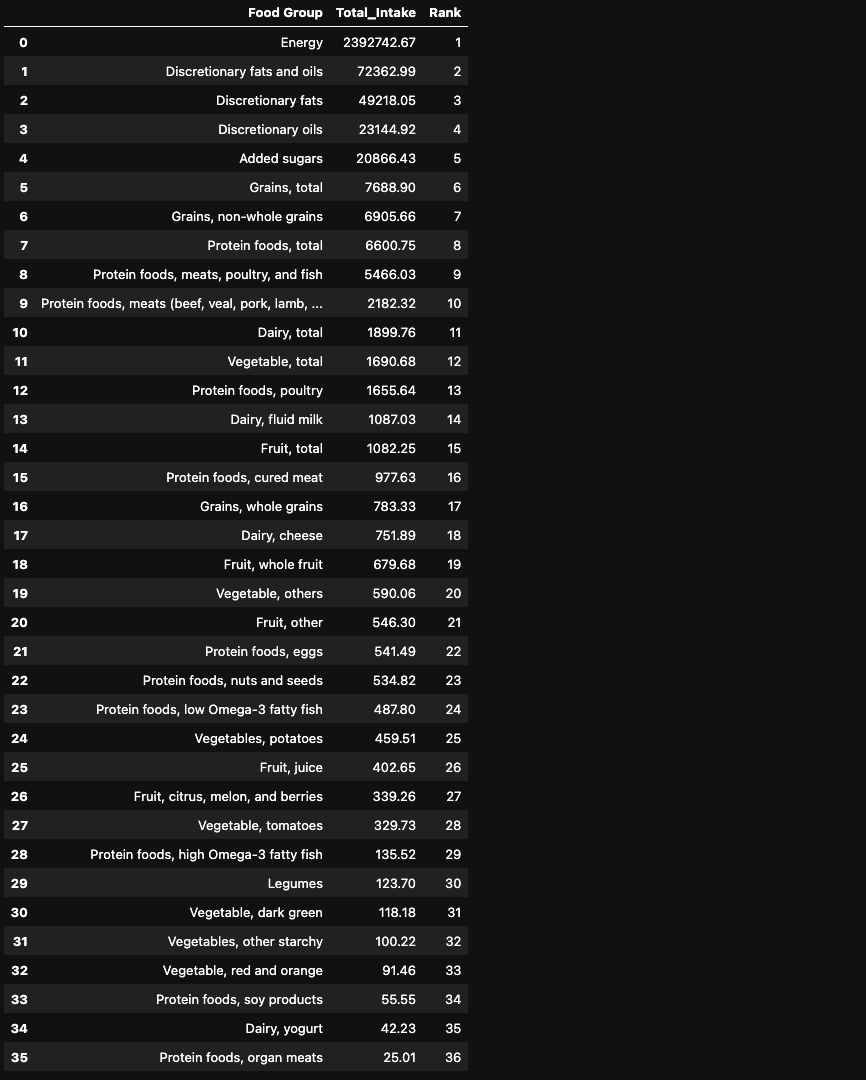

##Query 12: Placeholder Stored Procedure for Top-Spending State
What: This query illustrates how a stored procedure could be used to return the state with the highest total food sales in nominal dollars for a given year.

Why: We wanted to identify which states lead in overall food spending in a given year, as a way to highlight top-performing markets. This can help inform regional trends or marketing priorities based on spending concentration.

How: The query uses a subquery to find the maximum total sales for the selected year and returns the states that match that value. Please note that SQLite does not support stored procedures, but ideally this would be encapsulated in a reusable function.

This query features a stored procedure and subquery.

The expected output would be a state with the highest sales for a given target year input.


In [ ]:
-- Example stored procedure (not supported in SQLite)
-- CREATE PROCEDURE TopStateSales(IN target_year INT)
-- BEGIN
--   SELECT State, "Total Sales (Nominal $M)"
--   FROM sales
--   WHERE Year = target_year
--     AND "Total Sales (Nominal $M)" = (
--       SELECT MAX("Total Sales (Nominal $M)")
--       FROM sales
--       WHERE Year = target_year
--     );
-- END;

SyntaxError: invalid syntax (<ipython-input-4-d0d0fc8be832>, line 1)